<h1 align="center">Analysis of Metadata and Text for Level and Group Classification</h1>

We have two classification tasks:

* Predict the level, which ranges from 1-16.
* Predict the group of a given text, given this mapping from levels to group:
  - Levels 1-3 = Group A1
  - Levels 4-6 = Group A2
  - Levels 7-9 = Group B1
  - Levels 10-12 = Group B2
  - Levels 13-15 = Group C1
  - Levels 16 = Group C2

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd 
import numpy as np
import seaborn as sns

Here, we load the serialized DataFrame saved in step 1.

In [25]:
raw_input = pd.read_pickle('sample.pkl')

In [26]:
raw_input.head()

,article_id,grade,level,text,topic_id,topic_text,unit
546702,558652,90,1,"Dear Madam, How are you? This is Dave from Chi...",1,Introducing yourself by email,1
404822,413388,83,1,Hello! My name's Giller. I'm from Brazil and a...,1,Introducing yourself by email,1
923318,946256,100,1,"Good evening. How are you? I'm fine, thanks. W...",1,Introducing yourself by email,1
769679,788653,95,1,"Good evening. How are you? I'm fine , thanks. ...",1,Introducing yourself by email,1
614952,629221,95,1,"Dear Ms Thomas, There are thirteen computers a...",2,Taking inventory in the office,2


In [27]:
raw_input.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 546702 to 844382
Data columns (total 7 columns):
article_id    16000 non-null int64
grade         16000 non-null int64
level         16000 non-null int64
text          16000 non-null object
topic_id      16000 non-null int64
topic_text    16000 non-null object
unit          16000 non-null int64
dtypes: int64(5), object(2)
memory usage: 1000.0+ KB


# Map Level to Group

Next We map the `level` column to `group` to prepare for the second classification task.`

In [28]:
gp_mapper = {
    1: 'A1', 2: 'A1', 3: 'A1',
    4: 'A2', 5: 'A2', 6: 'A2',
    7: 'B1', 8: 'B1', 9: 'B1',
    10: 'B2', 11: 'B2', 12: 'B2',
    13: 'C1', 14: 'C1', 15: 'C1',
    16: 'C2'
}

raw_input = raw_input.assign(group=raw_input.level.map(gp_mapper))    

In [29]:
raw_input.head()

,article_id,grade,level,text,topic_id,topic_text,unit,group
546702,558652,90,1,"Dear Madam, How are you? This is Dave from Chi...",1,Introducing yourself by email,1,A1
404822,413388,83,1,Hello! My name's Giller. I'm from Brazil and a...,1,Introducing yourself by email,1,A1
923318,946256,100,1,"Good evening. How are you? I'm fine, thanks. W...",1,Introducing yourself by email,1,A1
769679,788653,95,1,"Good evening. How are you? I'm fine , thanks. ...",1,Introducing yourself by email,1,A1
614952,629221,95,1,"Dear Ms Thomas, There are thirteen computers a...",2,Taking inventory in the office,2,A1


# Check for Class Imbalance

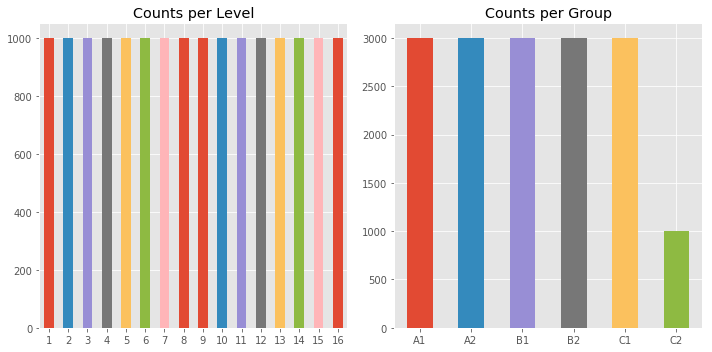

In [30]:
level_counts = raw_input.level.value_counts().sort_index()
group_counts = raw_input.group.value_counts().sort_index()

_, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = level_counts.plot(kind='bar', title='Counts per Level', ax=ax[0], rot=0)
_ = group_counts.plot(kind='bar', title='Counts per Group', ax=ax[1], rot=0)

plt.tight_layout()

# Level Classification Based on Text

In [31]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

en_stopwords = set(stopwords.words('english'))
print(en_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
{'this', 'shouldn', 'the', 'which', 'further', 'into', 'won', 'at', 'did', 'same', 'just', 'has', 'too', 'to', 'these', "wasn't", 'who', 'all', 'it', 'during', 'only', 'doing', 'not', 'ma', 'itself', 'or', 'do', 'for', 'needn', 'that', 'wouldn', 'ourselves', 'my', "that'll", 'own', "you've", 'mustn', 'been', 'them', 'whom', 'what', 'she', "don't", 'shan', 'yourself', 'such', 'those', 'ours', 'have', 'yourselves', "should've", "shouldn't", 'why', 'yours', 'through', 'other', 'because', 'be', 'some', 'he', 'o', 'how', 'before', 'in', 'll', 'out', 'an', 'above', 'didn', 'we', 'below', 'their', 're', "won't", 'more', 'herself', 'here', 'you', 'there', 'while', 'can', 'd', 'aren', 'from', 'being', 'of', 'under', 'having', 'about', 

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold


def classify_v1(input_df, target_label='level'):
    """
    Build a classifier for the `target_label` column in the DataFrame `input_df` using the `text` column.    
    Return the (labels, predicted_labels) tuple.    
    Use a 10-fold Stratified K-fold cross-validator to generate the out-of-sample predictions."""
    
    assert target_label in input_df.columns
    
    counter = TfidfVectorizer(
        ngram_range=(1, 2), 
        stop_words=en_stopwords, 
        max_df=0.4, 
        min_df=25, 
        max_features=3000, 
        sublinear_tf=True
    )

    scaler = StandardScaler(with_mean=False)
    model = LogisticRegression(penalty='l2', max_iter=200, random_state=4321)
    pipeline = make_pipeline(counter, scaler, model)

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

    X = raw_input.text
    y = raw_input.level
    y_pred = cross_val_predict(pipeline, X=X.values, y=y.values, cv=cv, n_jobs=16, verbose=2)
    y_pred = pd.Series(index=raw_input.index.copy(), data=y_pred)
    
    return y.copy(), y_pred

In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


def display_results(y, y_pred):
    """Given some predications y_pred for a target label y, 
    display the precision/recall/f1 score and the confusion matrix."""
        
    report = classification_report(y_pred, y)
    print(report)

    level_values = y.unique()
    level_values.sort()
    cm = confusion_matrix(y_true=y, y_pred=y_pred.values, labels=level_values)
    cm = pd.DataFrame(index=level_values, columns=level_values, data=cm)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax = sns.heatmap(cm, annot=True, ax=ax, fmt='d')

[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    9.6s remaining:   22.3s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    9.7s finished


             precision    recall  f1-score   support

          1       0.90      0.89      0.89      1011
          2       0.89      0.88      0.88      1017
          3       0.84      0.86      0.85       974
          4       0.86      0.88      0.87       980
          5       0.86      0.87      0.87       992
          6       0.83      0.86      0.85       969
          7       0.82      0.82      0.82      1005
          8       0.76      0.77      0.77       990
          9       0.82      0.81      0.81      1014
         10       0.85      0.88      0.86       966
         11       0.79      0.78      0.78      1011
         12       0.86      0.85      0.86      1021
         13       0.86      0.87      0.87       994
         14       0.88      0.85      0.86      1031
         15       0.81      0.79      0.80      1030
         16       0.86      0.87      0.86       995

avg / total       0.84      0.84      0.84     16000

CPU times: user 360 ms, sys: 196 ms, total:

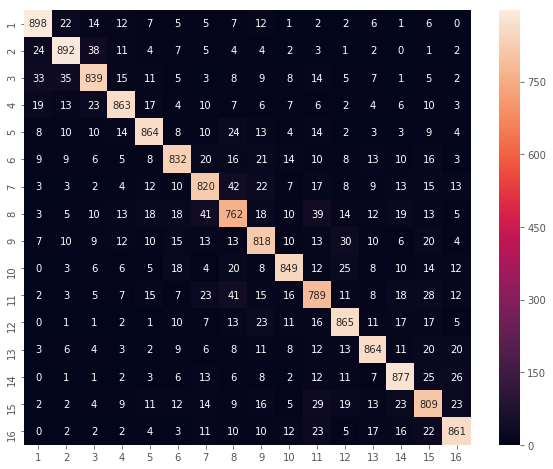

In [34]:
%%time
levels, levels_predicted = classify_v1(raw_input, target_label='level')
display_results(levels, levels_predicted)

# Misclassifications

Here we look at the misclassified samples to try to understand why the tf-idf model doesn't work for them.

In [35]:
# assign the predicated level as a column to the input data
input_with_preds = raw_input.assign(level_predicted=levels_predicted)
input_with_preds.head()

,article_id,grade,level,text,topic_id,topic_text,unit,group,level_predicted
546702,558652,90,1,"Dear Madam, How are you? This is Dave from Chi...",1,Introducing yourself by email,1,A1,2
404822,413388,83,1,Hello! My name's Giller. I'm from Brazil and a...,1,Introducing yourself by email,1,A1,1
923318,946256,100,1,"Good evening. How are you? I'm fine, thanks. W...",1,Introducing yourself by email,1,A1,1
769679,788653,95,1,"Good evening. How are you? I'm fine , thanks. ...",1,Introducing yourself by email,1,A1,1
614952,629221,95,1,"Dear Ms Thomas, There are thirteen computers a...",2,Taking inventory in the office,2,A1,1


We can identify the misclassified examples by the condition

    input_with_preds.level != input_with_preds.level_predicted
    
For these rows, we want to identify the pair ('level', 'level_predicted') that produces the greatest number of mismatches, because addressing these will produce the biggest improvement in the overall score.

In [36]:
misclassifications = input_with_preds[input_with_preds.level != input_with_preds.level_predicted]
m_counts = misclassifications.groupby(by=['level', 'level_predicted'])['text'].count()
m_counts.sort_values(ascending=False).head(5)

level  level_predicted
7      8                  42
8      7                  41
11     8                  41
8      11                 39
2      3                  38
Name: text, dtype: int64

Next we identify the articles with levels 7 and 8 that have been misclassified as 8 and 7. 

In [37]:
cond = (misclassifications.level.isin([7, 8])) & (misclassifications.level_predicted.isin([7, 8]))
mis_sample = misclassifications.loc[cond, ['topic_text', 'topic_id', 'text', 'level', 'level_predicted']]
mis_sample.groupby(['topic_id', 'topic_text', 'level', 'level_predicted'])['text'].count().sort_values(ascending=False)

topic_id  topic_text                            level  level_predicted
50        Planning for the future               7      8                  28
59        Making a 'to do' list of your dreams  8      7                  21
62        Responding to written invitations     8      7                   6
60        Describing a business trip            8      7                   5
63        Congratulating a friend on an award   8      7                   4
52        Writing about a memorable experience  7      8                   4
61        Selling items in an online auction    8      7                   3
54        Issuing a written warning             7      8                   3
49        Giving instructions to play a game    7      8                   3
51        Writing a job advertisement           7      8                   2
64        Claiming back your security deposit   8      7                   1
58        Reviewing a song for a website        8      7                   1
55   

So, most of the misclassifications for true level 7 occur for the topic "Planning for the future", whereas for level 8, it is 
"Making a 'to do' list of your dreams". Intuitively, this makes sense. These two topics are similar, so the word frequency distributions could very well be similar.

Next we extract wordcount tf-idf matrices for a subset of these articles and compare different aspects of them.

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

def calc_bow_matrix_for_topic_id(df, topic_id, limit=5):
    """Return a dense DataFrame of Word counts with words as index, article IDs as columns."""
    all_texts = df[df.topic_id == topic_id].text.head(limit)

    cv = CountVectorizer(stop_words=en_stopwords)
    t = cv.fit_transform(all_texts.values)
    words = cv.get_feature_names()

    tf_idf_matrix = pd.DataFrame(index=all_texts.index.copy(), columns=words, data=t.todense()).T
    return tf_idf_matrix

tid_50, tid_59 = map(lambda x: calc_bow_matrix_for_topic_id(mis_sample, x), [50, 59])

In [39]:
tid_50.head(20)

,674236,96752,705243,1127742,919045
abroad,0,1,3,0,0
advices,0,0,0,0,1
afterwards,0,1,0,0,0
already,0,0,2,0,0
also,1,0,0,0,0
always,2,0,0,0,1
another,0,0,2,0,0
answer,0,0,0,0,1
apply,0,1,0,0,0
beate,0,0,0,1,0


In [40]:
tid_59.head(20)

,49823,605166,745615,1136838,1122750
50,0,0,1,0,0
abroad,0,0,0,0,1
achievement,0,1,0,0,0
aim,0,1,0,0,0
also,0,0,0,0,1
america,1,0,0,0,0
annual,0,0,1,0,0
another,1,0,0,0,0
apply,0,0,0,0,1
around,0,0,0,1,0


In [41]:
uncommon_words = tid_50.index.symmetric_difference(tid_59.index).tolist()
print(uncommon_words)

['50', 'achievement', 'advices', 'afterwards', 'aim', 'already', 'always', 'america', 'annual', 'answer', 'around', 'australia', 'beate', 'believe', 'believed', 'best', 'big', 'bigger', 'bit', 'bought', 'boyfriend', 'boys', 'brand', 'calling', 'came', 'careers', 'carry', 'cat', 'certainly', 'challenging', 'cheer', 'children', 'city', 'clothes', 'company', 'countries', 'course', 'culture', 'daddy', 'davidson', 'day', 'dear', 'design', 'designer', 'designing', 'develop', 'doc', 'dog', 'dreaming', 'driving', 'easy', 'education', 'employers', 'english', 'enrol', 'erasmus', 'everytime', 'examination', 'expensive', 'experience', 'experiences', 'fairs', 'family', 'famous', 'fashion', 'father', 'fellowship', 'ferraro', 'finish', 'finished', 'first', 'five', 'football', 'francesco', 'gap', 'girls', 'go', 'going', 'graduate', 'graduation', 'great', 'hand', 'hard', 'hardworking', 'harley', 'help', 'hi', 'highschool', 'hoping', 'idea', 'important', 'income', 'intend', 'interesting', 'joyfully', 'j

So the word count matrix is extremely sparse and a fair amount of words only appear in one set of articles and not the other. Based on that, I concluded that the presence / absence of rare words could be a better indicator of level instead of tf-idf. 

Next we re-run the model evaluation step using binary valued features indicating presence / absence.

# Improving the Model

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold


def classify_v2(input_df, target_label='level'):
    """
    Build a classifier for the `target_label` column in the DataFrame `input_df` using the `text` column.    
    Return the (labels, predicted_labels) tuple.    
    Use a 10-fold Stratified K-fold cross-validator to generate the out-of-sample predictions."""
    
    assert target_label in input_df.columns
    
    counter = CountVectorizer(
        lowercase=True, 
        stop_words=en_stopwords, 
        ngram_range=(1, 1),        
        min_df=5,
        max_df=0.4,
        binary=True)

    model = LogisticRegression(
        penalty='l2', 
        max_iter=200, 
        multi_class='multinomial', 
        solver='lbfgs', 
        verbose=True,
        random_state=4321)
    
    pipeline = make_pipeline(counter, model)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

    X = input_df.text
    y = input_df.loc[:, target_label]
    y_pred = cross_val_predict(pipeline, X=X.values, y=y.values, cv=cv, n_jobs=10, verbose=2)
    y_pred = pd.Series(index=raw_input.index.copy(), data=y_pred)

    return y.copy(), y_pred

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.6s finished
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:   30.0s remaining:  1.2min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.4s finished
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   31.7s finished


             precision    recall  f1-score   support

          1       0.94      0.85      0.89      1098
          2       0.91      0.88      0.89      1040
          3       0.90      0.88      0.89      1020
          4       0.90      0.90      0.90      1005
          5       0.89      0.88      0.88      1011
          6       0.90      0.86      0.88      1036
          7       0.86      0.84      0.85      1024
          8       0.80      0.81      0.80       998
          9       0.85      0.85      0.85       992
         10       0.87      0.90      0.89       968
         11       0.82      0.83      0.82       984
         12       0.85      0.86      0.86       985
         13       0.88      0.90      0.89       982
         14       0.88      0.91      0.89       963
         15       0.80      0.85      0.82       931
         16       0.88      0.91      0.90       963

avg / total       0.87      0.87      0.87     16000

CPU times: user 324 ms, sys: 200 ms, total:

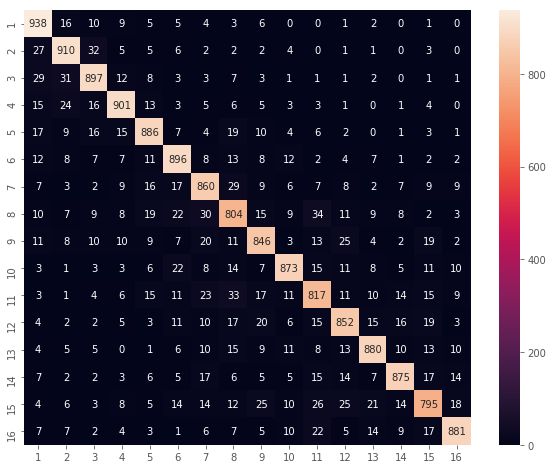

In [43]:
%%time
levels, levels_predicted = classify_v2(raw_input, target_label='level')
display_results(levels, levels_predicted)

Using binary features the composite f1-score has improved to **0.87** from **0.84**.

# Group Classification Based on Text

This is essentially the same classification problem as the `level` classification but with collapsed categories, so my intutition is that the same feature-classifier combination will work well and should produce slightly better performance.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.6s finished
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:   22.7s remaining:   52.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.5s finished
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   24.0s finished


             precision    recall  f1-score   support

         A1       0.96      0.92      0.94      3145
         A2       0.89      0.89      0.89      3011
         B1       0.86      0.85      0.86      3040
         B2       0.87      0.86      0.87      3023
         C1       0.87      0.89      0.88      2924
         C2       0.80      0.94      0.86       857

avg / total       0.89      0.89      0.89     16000

CPU times: user 400 ms, sys: 168 ms, total: 568 ms
Wall time: 24.3 s


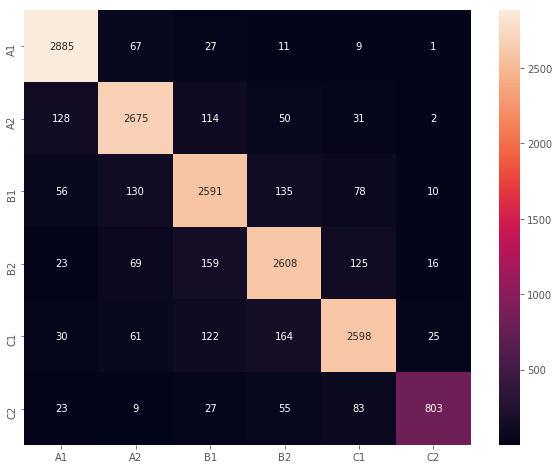

In [44]:
%%time

groups, groups_predicted = classify_v2(raw_input, target_label='group')
display_results(groups, groups_predicted)